=== Handle imports and paths ===

In [1]:
import sys
sys.path.append('/mnt/md0/tempFolder/samAnderson/gnn_model/unet-gnn/') 
sys.path.append('/mnt/md0/tempFolder/samAnderson/gnn_model/unet-gnn/functions/') 
from paths_and_imports import *
from control_flow_functions import *
from nn_optim_unet import *
from postprocessing import *
from dataset_config import datasets
%load_ext autoreload
%autoreload 2

/mnt/md0/tempFolder/samAnderson/gnn_model/unet-gnn/env_gnn/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


=== Load the trained model ===

In [2]:
trained_model = get_gnn(fs=feature_scale, dropout_levels=dropout_levels, 
                           pooling_path=pooling_path, ico_levels=ico_levels)    
trained_model.load_state_dict(torch.load(f'{output_dir}trained_weights.pth'))

<All keys matched successfully>

=== Run integrated grad to determine feature significance ===

In [4]:
suffix='test_CN' # which set is grad
paths, path_titles = integrated_grad(X_test_CN, y_test_CN, model=None, # None is fine when load=True
                             test_size=128, suffix=suffix,
                             order=['area', 'thickness', 'WM-GM_ratio', 'curvature', 'sulcal_depth'],
                             both_angles=['area', 'thickness', 'WM-GM_ratio', 'curvature', 'sulcal_depth'], 
                             load=True, n_columns=2, abs_lims=[25, 25, 10, 6, 1])

     feature  temporal  parietal   frontal  occipital
        area 13.100756 11.494273 13.380514   8.921553
   thickness  6.105230 10.760329  8.533125  15.012109
 WM-GM_ratio  5.000370  4.944043  5.686736   4.312794
   curvature -1.964379 -1.790925 -2.832527  -2.657396
sulcal_depth -0.646502 -0.554410 -0.686622  -0.756332


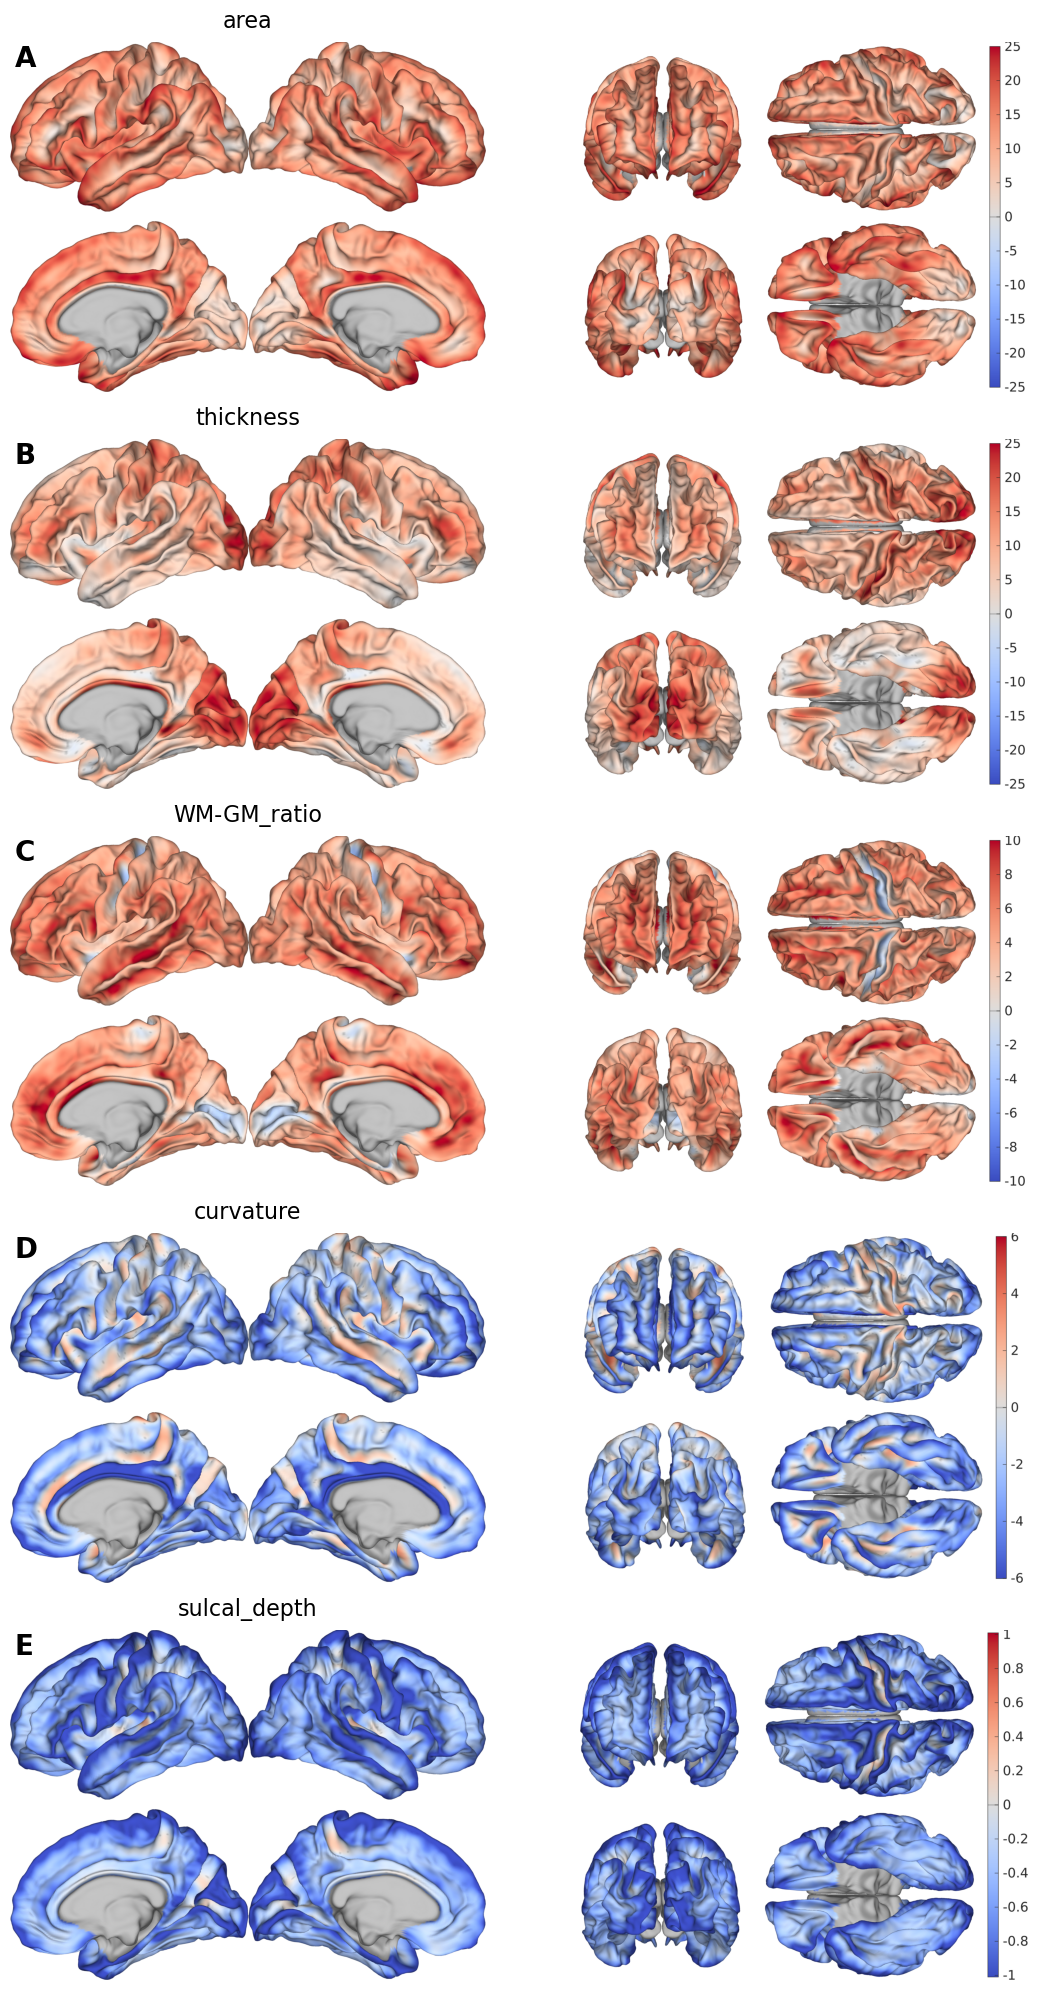

In [5]:
# Labels for the subplots (every other one blank)
subplot_labels = ['A', '', 'B', '', 'C', '', 'D', '', 'E', '']

fig, axes = plt.subplots(5, 2, figsize=(12, 20))  # 5 rows, 2 columns
axes = axes.ravel()  # Flatten to 1D for easy indexing

# Plot images
for i, ax in enumerate(axes):
    if i < len(paths):  # Only plot if there is an image
        img = mpimg.imread(paths[i])
        ax.imshow(img)
        ax.axis('off')

        if subplot_labels[i] != '':  # Only add label if not blank
            ax.text(0.01, 0.99, subplot_labels[i], transform=ax.transAxes,
                    fontsize=20, fontweight='bold', va='top', ha='left',
                    bbox=dict(facecolor='white', edgecolor='none'))
        ax.set_title(path_titles[i], fontsize=16, pad=10)
    else:
        ax.axis('off')  # Hide any empty axes

plt.tight_layout()

Get the top and bottom 5 regions across both hemis

In [57]:
suffix = 'test_CN'
p = postprocess()

for feature in ['area', 'thickness', 'WM-GM_ratio', 'curvature', 'sulcal_depth']:
    grad_array = scipy.io.loadmat(f'{output_dir}{suffix}_{feature}_integrated_grad')['data'].squeeze()    
    region_stats_df = (
        p.get_region_stats(grad_array)
         .drop_duplicates(subset=["region"])
         .sort_values(by="age_gap", ascending=False)
    )
    
    print(f'\n\t\t\t===== {feature} =====\n')
    print(pd.concat([region_stats_df.head(5), region_stats_df.tail(5)]))


			===== area =====

                      region hemi  age_gap  variance  skew  region_avg
105            G_subcallosal   lh    19.68      2.12 -0.68       18.15
12       G_front_inf-Orbital   rh    18.42      6.65 -0.46       17.93
13      G_front_inf-Triangul   rh    16.98     19.25 -0.63       14.75
97                 G_orbital   lh    16.51     10.57 -0.51       16.34
51               S_front_inf   rh    16.38     10.54  0.24       15.71
145           S_temporal_inf   lh     8.58     11.39  0.16        7.94
72            S_temporal_sup   rh     8.02     22.07  0.79        7.90
130  S_oc_middle_and_Lunatus   lh     6.38      8.18  0.26        6.14
92        G_occipital_middle   lh     5.81     12.49  0.87        5.52
58           S_occipital_ant   rh     3.92      4.99  0.41        3.55

			===== thickness =====

                      region hemi  age_gap  variance  skew  region_avg
132          S_occipital_ant   lh    21.54      5.35 -0.66       20.70
18        G_occipital_middle

Create a combined df and save it

In [5]:
suffix = 'test_CN'
p = postprocess()

all_features = ['area', 'thickness', 'WM-GM_ratio', 'curvature', 'sulcal_depth']
dfs = []

for feature in all_features:
    grad_array = scipy.io.loadmat(f'{output_dir}{suffix}_{feature}_integrated_grad')['data'].squeeze()
    region_stats_df = (
        p.get_region_stats(grad_array)
         .assign(feature=feature)
    )
    dfs.append(region_stats_df)

# Combine all into one dataframe, sorted by feature and age_gap
combined_df = (
    pd.concat(dfs, ignore_index=True)
      .sort_values(by=["feature", "age_gap"], ascending=[True, False])
      .reset_index(drop=True))

combined_df.to_excel(f'{output_dir}{suffix}_all_integrated_gradients.xlsx')

Now do the same for ADs, using a random sample of CNs as the baseline

In [2]:
suffix='test_AD' # which set is grad
paths, path_titles = integrated_grad(X_test_AD, y_test_AD, model=None, # None is fine when load=True
                             test_size=128, suffix=suffix,
                             order=['area', 'thickness', 'WM-GM_ratio', 'curvature', 'sulcal_depth'],
                             both_angles=['area', 'thickness', 'WM-GM_ratio', 'curvature', 'sulcal_depth'], 
                             load=True, n_columns=2, abs_lims=[0.5, 0.5, 0.8, 0.5, 0.5],
                             baseline=X_test_CN) # use CN predictions as baseline

     feature  temporal  parietal  frontal  occipital
        area  0.161173  0.127306 0.117084   0.127024
   thickness  0.149656  0.144041 0.123971   0.127380
 WM-GM_ratio  0.259346  0.262089 0.247411   0.272521
   curvature  0.003218 -0.042182 0.030269  -0.066168
sulcal_depth  0.099514  0.123138 0.100411   0.105254


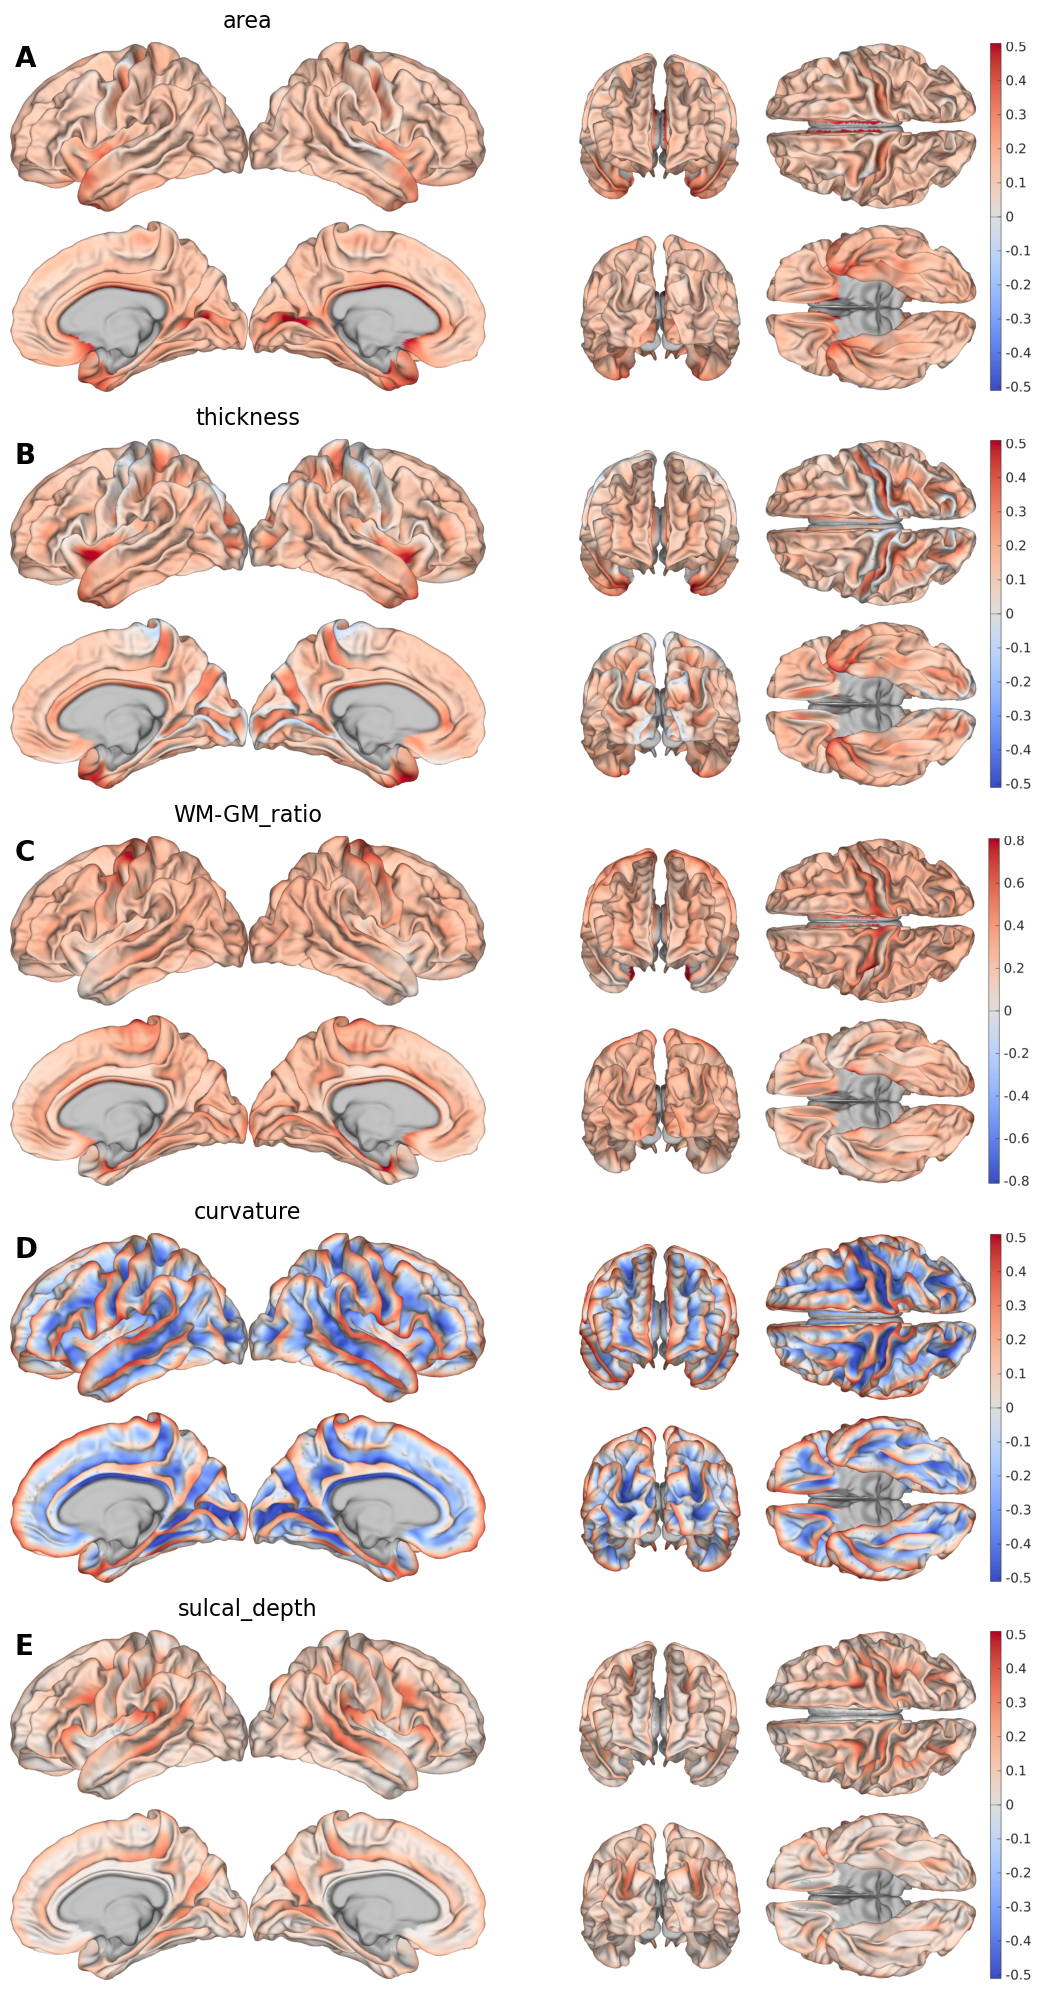

In [4]:
# Labels for the subplots (every other one blank)
subplot_labels = ['A', '', 'B', '', 'C', '', 'D', '', 'E', '']

fig, axes = plt.subplots(5, 2, figsize=(12, 20))  # 5 rows, 2 columns
axes = axes.ravel()  # Flatten to 1D for easy indexing

# Plot images
for i, ax in enumerate(axes):
    if i < len(paths):  # Only plot if there is an image
        img = mpimg.imread(paths[i])
        ax.imshow(img)
        ax.axis('off')

        if subplot_labels[i] != '':  # Only add label if not blank
            ax.text(0.01, 0.99, subplot_labels[i], transform=ax.transAxes,
                    fontsize=20, fontweight='bold', va='top', ha='left',
                    bbox=dict(facecolor='white', edgecolor='none'))
        ax.set_title(path_titles[i], fontsize=16, pad=10)
    else:
        ax.axis('off')  # Hide any empty axes

plt.tight_layout()

In [3]:
suffix = 'test_AD'
p = postprocess()

for feature in ['area', 'thickness', 'WM-GM_ratio', 'curvature', 'sulcal_depth']:
    grad_array = scipy.io.loadmat(f'{output_dir}{suffix}_{feature}_integrated_grad')['data'].squeeze()    
    region_stats_df = (
        p.get_region_stats(grad_array)
         .drop_duplicates(subset=["region"])
         .sort_values(by="region_avg", ascending=False)
    )
    
    print(f'\n\t\t\t===== {feature} =====\n')
    print(pd.concat([region_stats_df.head(5), region_stats_df.tail(5)]))


			===== area =====

                     region hemi  age_gap  variance  skew  region_avg
106   G_temp_sup-G_T_transv   lh     0.87      0.00 -0.21        0.87
147   S_temporal_transverse   lh     0.81      0.00 -0.13        0.81
121   S_circular_insula_inf   lh     0.83      0.00 -1.20        0.81
34    G_temp_sup-Plan_polar   rh     0.69      0.03 -0.27        0.67
33       G_temp_sup-Lateral   rh     0.69      0.05 -1.06        0.63
24     G_pariet_inf-Angular   rh     0.13      0.00  0.31        0.12
83    G_cingul-Post-ventral   lh     0.12      0.00 -0.13        0.11
19          G_occipital_sup   rh     0.12      0.00  0.17        0.11
67    S_precentral-inf-part   rh     0.12      0.00  0.09        0.11
6    G_and_S_cingul-Mid-Ant   rh     0.11      0.00 -0.47        0.11

			===== thickness =====

                      region hemi  age_gap  variance  skew  region_avg
40              Lat_Fis-post   rh     0.27      0.00 -1.24        0.26
147    S_temporal_transverse   lh     0

Create a combined df and save it

In [6]:
suffix = 'test_AD'
p = postprocess()

all_features = ['area', 'thickness', 'WM-GM_ratio', 'curvature', 'sulcal_depth']
dfs = []

for feature in all_features:
    grad_array = scipy.io.loadmat(f'{output_dir}{suffix}_{feature}_integrated_grad')['data'].squeeze()
    region_stats_df = (
        p.get_region_stats(grad_array)
         .assign(feature=feature)
    )
    dfs.append(region_stats_df)

# Combine all into one dataframe, sorted by feature and age_gap
combined_df = (
    pd.concat(dfs, ignore_index=True)
      .sort_values(by=["feature", "age_gap"], ascending=[True, False])
      .reset_index(drop=True))

combined_df.to_excel(f'{output_dir}{suffix}_all_integrated_gradients.xlsx')